In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
import glob
import numpy as np
from PIL import Image
from sklearn.metrics import pairwise_distances, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
import sys
sys.path.append("../")
from inception_resnet_v1 import inference

import seaborn as sns

In [2]:
def prewhiten(x):
    """
    A helper function to whiten an image, or a batch of images.
    Args:
        x: An image or batch of images.
    """
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        print(x.ndim)
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
#     std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    """
    Normalizes an embedding to have unit length in the l2 metric.
    Args:
        x: A batch of numpy embeddings
    """
    output = x / np.sqrt(np.maximum(np.sum(np.square(x),
                                           axis=axis,
                                           keepdims=True),
                                    epsilon))
    return output

In [3]:
class PersonImages:
    def __init__(self, person_name):
        self.clean_folder = ""
        self.clean_images = []
        self.adversarial_images = []
        self.orig_mean = None
        self.orig_std = None
        self.orig_paths = []
        self.person_name = person_name
    
    def _load_one_facenet(self, path, resize_size=None, prewhiten_img=True):
        img = Image.open(path).convert("RGB")
    
            
        if resize_size:
            img = img.resize((resize_size, resize_size))
            
        img = (np.array(img)).astype(np.float32)
        
        if prewhiten_img:
            img = prewhiten(img)
            
        return img
        
    def _load_folder_for_facenet(self, folder, resize_size=None):
        paths_list = glob.glob(os.path.join(folder, "*"))
        final_imgs = []
        for img_path in paths_list:
            final_imgs.append(
                self._load_one_facenet(
                    img_path, prewhiten_img=False, resize_size=resize_size))
        
        final_imgs = np.array(final_imgs)
        mean, std = np.mean(final_imgs), np.std(final_imgs)
        final_imgs = prewhiten(np.array(final_imgs))
        return final_imgs, mean, std, paths_list
        
    def load_clean_from_folder(self, clean_folder, resize_size=160):
        self.clean_folder = clean_folder
        self.clean_images, self.orig_mean, self.orig_std, self.orig_paths = self._load_folder_for_facenet(
            clean_folder, resize_size=resize_size)
    
    def _undo_preprocess(self, images):
        restored_images = images.copy()
        restored_images  *= self.orig_std
        restored_images += self.orig_mean
        restored_images = np.clip(restored_images, 0.0, 255.0)
        return np.uint8(restored_images)
    
    def _compute_embeddings(self, model, images):
        return model.predict(np.array(images), batch_size=len(images))
    
    def get_clean_for_display(self):
        return self._undo_preprocess(self.clean_images)
    
    def compute_clean_embeddings_with_model(self, model):
        self.clean_embeddings = self._compute_embeddings(model, self.clean_images)

In [4]:
class MyModel:
    def __init__(self, model_path, inputs=None, sess=None, graph=None):
        if graph is None:
            self.graph = tf.Graph()
        else:
            self.graph = graph
            
        with self.graph.as_default():
            if inputs is None:
                self.model_inputs = tf.placeholder(tf.float32, shape=(None, 160, 160, 3))
            else:
                self.model_inputs = inputs

            vars_before = tf.global_variables()
            self.net, self.endpoints = inference(
                self.model_inputs, keep_probability=1.0, bottleneck_layer_size=512, phase_train=False)
            vars_after = tf.global_variables()

            model_name = dataset_to_model_name["vggface2"]
            saver = tf.train.Saver(list(set(vars_after) - set(vars_before)))

            if sess is None:
                self.sess = tf.Session()
            else:
                self.sess = sess

            saver.restore(self.sess, model_path)
    
    def predict(self, inputs, batch_size):
        with self.graph.as_default():
            return self.sess.run(self.net, feed_dict={self.model_inputs: inputs})
    
    def __del__(self):
        self.sess.close()

dataset_to_model_name = {
    "casia-webface": "20180408-102900",
    "vggface2": "20180402-114759"
}

dataset_to_ckpt_number = {
    "casia-webface": "90",
    "vggface2": "275"
}

def build_model(dataset_name, inputs=None, sess=None, graph=None):
    model_name = dataset_to_model_name[dataset_name]
    model = MyModel(
        os.path.join(
            "/home/ivan/facenet/models",
            model_name,
            "model-{model_name}.ckpt-{ckpt_num}".format(
                model_name=dataset_to_model_name[dataset_name],
                ckpt_num=dataset_to_ckpt_number[dataset_name]
            )),
        inputs, 
        sess,
        graph
    )
    return model

def build_vggface_model(inputs, sess, graph):
    return build_model("vggface2", inputs, sess, graph)

def build_casiawebface_model(inputs, sess, graph):
    return build_model("casia-webface", inputs, sess, graph)

In [5]:
def path_for_id_clean(identity):
    if identity == "n000958":
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000029/epsilon_0.0/png".format(id=identity)
    else:
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000958/epsilon_0.0/png".format(id=identity)
    

In [6]:
def build_person(person_name, path_for_id_fn, model=None):
    person_a = PersonImages(person_name)
    person_a.load_clean_from_folder(path_for_id_fn(person_a.person_name))
    if model is not None:
        print("Computing embeddings for", person_name)
        person_a.compute_clean_embeddings_with_model(model)
    return person_a

In [7]:
def attack_batch_cw(
    build_model_fn, 
    input_images,
    target_vectors,
    learning_rate,
    epsilon,
    max_iters
):
    input_images = np.array(input_images)
    batch_size, orig_h, orig_w, orig_c = input_images.shape
    
    graph = tf.Graph()
    
    with graph.as_default():
        with tf.Session() as sess:
            targets_var = tf.get_variable(
                name="targets",
                shape=target_vectors.shape,
            )
            sess.run(tf.assign(targets_var, target_vectors))
            
            images_input_ph = tf.placeholder(
                tf.float32,
                name="input_images",
                shape=input_images.shape
            )
            
            noise_var = tf.get_variable(
                name="adversarial_noise",
                shape=input_images.shape,
                initializer=tf.initializers.truncated_normal(
                    mean=np.mean(input_images),
                    stddev=3 * np.std(input_images)
                )
            )
            sess.run(noise_var.initializer)
            
            images_plus_noise = images_input_ph + noise_var

            randomized_images_plus_noise = tf.image.random_brightness(
                images_plus_noise, 0.5)
        
            randomized_images_plus_noise = tf.image.random_crop(
                randomized_images_plus_noise, 
                [batch_size, orig_h - 10, orig_w - 10, 3]
            )

            randomized_images_plus_noise = tf.image.resize_images(
                randomized_images_plus_noise, [orig_h, orig_w])
            
            randomized_images_plus_noise += tf.random.normal(
                randomized_images_plus_noise.shape, 0.0, 0.75)
            
            randomized_images_plus_noise = tf.clip_by_value(
                randomized_images_plus_noise, input_images - epsilon, input_images + epsilon)
            
            model = build_model_fn(
                inputs=randomized_images_plus_noise, 
                sess=sess,
                graph=graph
            )
            
            model_outputs = tf.nn.l2_normalize(model.net, axis=1)
            targets = tf.nn.l2_normalize(targets_var, axis=1)
            loss = tf.losses.cosine_distance(targets, model_outputs, axis=1)
        
            total_loss = loss + 1e-6 * tf.nn.l2_loss(noise_var)
            
            vars_before = set(tf.global_variables())
            train_op = tf.train.AdamOptimizer(learning_rate).minimize(
                total_loss, var_list=[noise_var])
            vars_after = set(tf.global_variables())
            sess.run([v.initializer for v in list(vars_after - vars_before)])
            
            
            losses = []
            for i in range(max_iters):
                loss_value, total_loss_value, _ = sess.run(
                    [loss, total_loss, train_op], feed_dict={images_input_ph: input_images})
                assert not np.isnan(loss_value), "Loss_value is nan"
                losses.append(loss_value)
            
            final_imgs = sess.run(
                tf.clip_by_value(images_plus_noise, input_images - epsilon, input_images + epsilon),
                feed_dict={images_input_ph: input_images}
            )
            
            return final_imgs, losses

In [8]:
def generate_decoys_bigger_batches(
    attack_strategy,
    model_to_attack,
    learning_rate,
    epsilon,
    max_iters
):
    model = build_model(model_to_attack)
    people_list = [
        build_person(person_name, path_for_id_clean, model) \
        for person_name in os.listdir("/data/vggface/test_perturbed_sampled")
    ]
    del model
    
    if model_to_attack == "vggface2":
        model_build_fn = build_vggface_model
    elif model_to_attack == "casia-webface":
        model_build_fn = build_casiawebface_model
        
    for person in tqdm(people_list):
        num, height, width, channels = person.clean_images.shape
        person.adversarial_images = np.zeros((2*(len(people_list) - 1), height, width, channels))
        
        indx = 0
        
        images_to_make_adversarial = []
        targets_for_images = []
        
        for other_person in people_list:
            if person.person_name == other_person.person_name:
                continue
                
            current_chosen_indices = range(indx, indx + 2)
            images_to_make_adversarial.extend(np.take(
                person.clean_images, current_chosen_indices, axis=0))
            
            target_vector = np.mean(other_person.clean_embeddings, axis=0)
            targets_for_images.extend(np.array([
                target_vector for _ in range(len(current_chosen_indices))]))
            
            indx += 2
            
        images_to_make_adversarial = np.array(images_to_make_adversarial)
        
        all_adversarial_images, losses = attack_batch_cw(
            model_build_fn, 
            np.array(images_to_make_adversarial),
            np.array(targets_for_images),
            learning_rate,
            epsilon,
            max_iters
        )
            
        fig, ax = plt.subplots()
        ax.plot(range(len(losses)), losses)
        plt.show()
        
        indx = 0
        for other_person in people_list:
            if person.person_name == other_person.person_name:
                continue
            
            save_dest = os.path.join(
                "/data/vggface/test_perturbed_sampled",
                person.person_name,
                "{attack_strategy}_{model}".format(attack_strategy=attack_strategy, model=model_to_attack),
                other_person.person_name
            )
            
            save_path = os.path.join(save_dest, "epsilon_{}".format(epsilon), "png")
            os.makedirs(save_path, exist_ok=True)
            existing_files = os.listdir(save_path)

            # Clean up folder if need be
            if len(existing_files) > 0:
                for f in existing_files:
                    os.remove(os.path.join(save_path, f))
            
            for i in range(indx, indx + 2):
                orig_name = person.orig_paths[i].split("/")[-1]
                person.adversarial_images[i] = all_adversarial_images[i]
                full_save_path = os.path.join(save_path, orig_name)
                print("Saving to", save_path)
                Image.fromarray(
                    person._undo_preprocess(person.adversarial_images[i])
                ).save(full_save_path)

            indx += 2

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Computing embeddings for n001781
Computing embeddings for n009232
Computing embeddings for n000958
Computing embeddings for n003356
Computing embeddings for n008655
Computing embeddings for n008613
Computing embeddings for n004658
Computing embeddings for n001683
Computing embeddings for n002647
Computing embeddings for n009288
Computing embeddings for n005427
Computing embeddings for n002763
Computing embeddings for n002503
Computing embeddings for n003215
Computing embeddings for n005359
Computing embeddings for n005303
Computing embeddings for n007548


  0%|          | 0/19 [00:00<?, ?it/s]

Computing embeddings for n000029
Computing embeddings for n009114
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


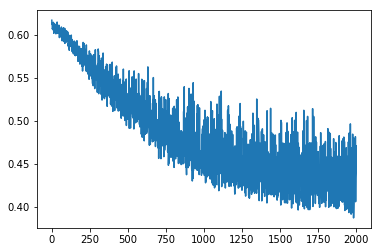

Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

  5%|▌         | 1/19 [03:37<1:05:12, 217.38s/it]

Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


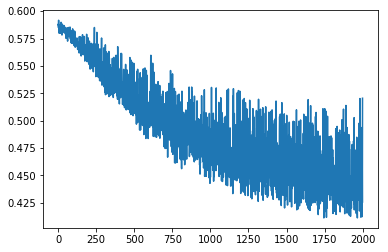

Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

 11%|█         | 2/19 [07:12<1:01:24, 216.71s/it]

Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/2

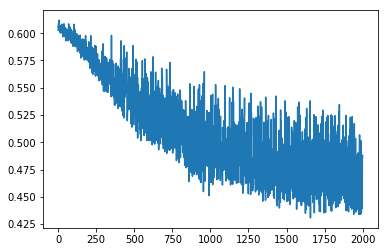

Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

 16%|█▌        | 3/19 [10:47<57:38, 216.15s/it]  

Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/2

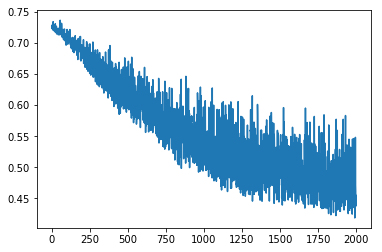

Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

 21%|██        | 4/19 [14:22<53:55, 215.72s/it]

Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


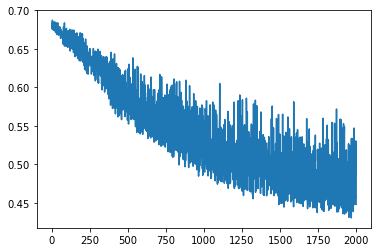

Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

 26%|██▋       | 5/19 [17:56<50:13, 215.27s/it]

Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


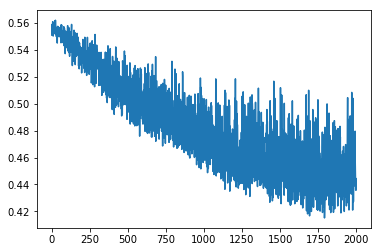

Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 32%|███▏      | 6/19 [21:30<46:34, 214.93s/it]

Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


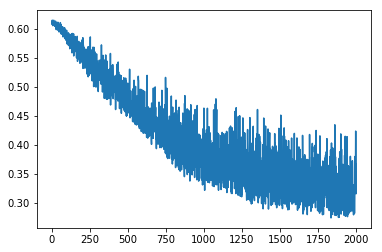

Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 37%|███▋      | 7/19 [25:03<42:52, 214.38s/it]

Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


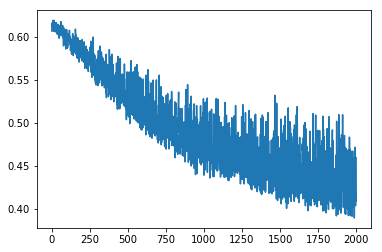

Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 42%|████▏     | 8/19 [28:37<39:17, 214.30s/it]

Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n002503/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggf

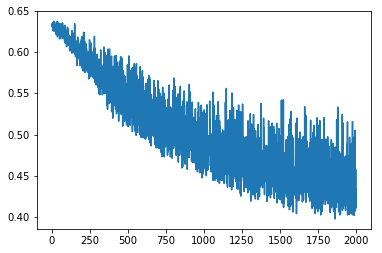

Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 47%|████▋     | 9/19 [32:13<35:47, 214.72s/it]

Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


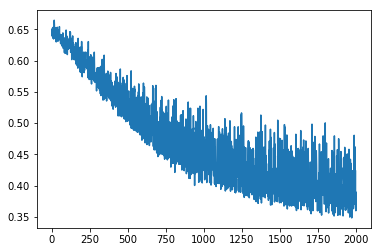

Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 53%|█████▎    | 10/19 [35:47<32:10, 214.55s/it]

Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scal

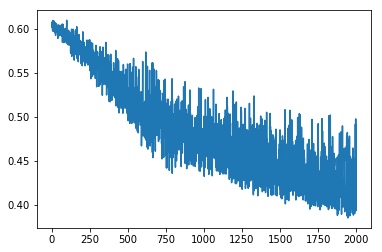

Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 58%|█████▊    | 11/19 [39:19<28:30, 213.87s/it]

Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggf

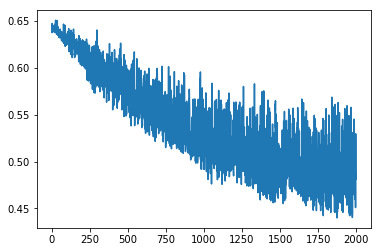

Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 63%|██████▎   | 12/19 [42:53<24:56, 213.72s/it]

Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scal

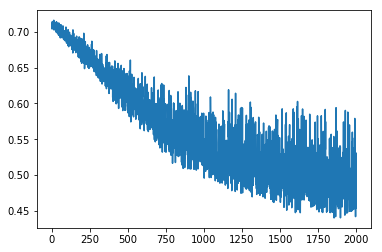

Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 68%|██████▊   | 13/19 [46:26<21:21, 213.53s/it]

Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


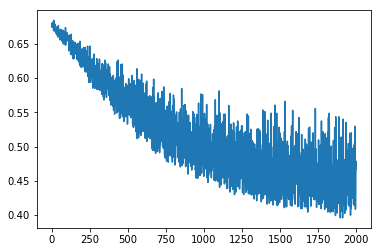

Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 74%|███████▎  | 14/19 [50:00<17:48, 213.76s/it]

Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


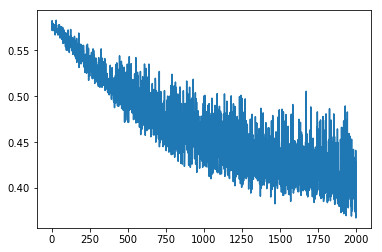

Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 79%|███████▉  | 15/19 [53:36<14:18, 214.52s/it]

Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scal

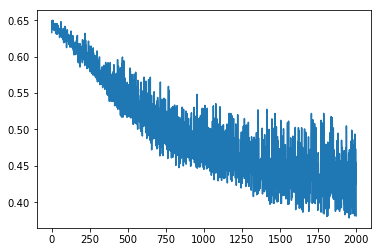

Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 84%|████████▍ | 16/19 [57:10<10:42, 214.18s/it]

Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scal

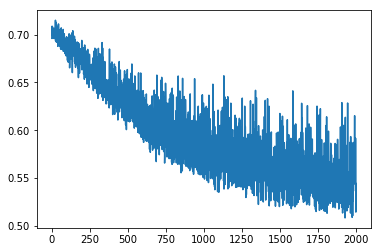

Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 89%|████████▉ | 17/19 [1:00:44<07:08, 214.14s/it]

Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


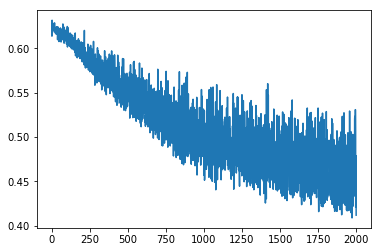

Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 95%|█████████▍| 18/19 [1:04:17<03:33, 213.91s/it]

Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n002503/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggf

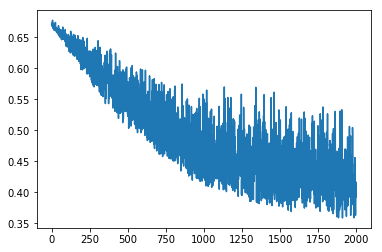

Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

100%|██████████| 19/19 [1:07:52<00:00, 214.36s/it]

Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_casia-webface/n000029/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Computing embeddings for n001781
Computing embeddings for n009232
Computing embeddings for n000958
Computing embeddings for n003356
Computing embeddings for n008655
Computing embeddings for n008613
Computing embeddings for n004658
Computing embeddings for n001683
Computing embeddings for n002647
Computing embeddings for n009288
Computing embeddings for n005427
Computing embeddings for n002763
Computing embeddings for n002503
Computing embeddings for n003215
Computing embeddings for n005359
Computing embeddings for n005303
Computing embeddings for n007548


  0%|          | 0/19 [00:00<?, ?it/s]

Computing embeddings for n000029
Computing embeddings for n009114
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


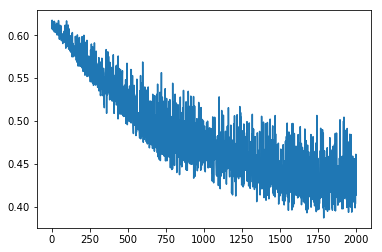

Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

  5%|▌         | 1/19 [03:34<1:04:20, 214.48s/it]

Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scal

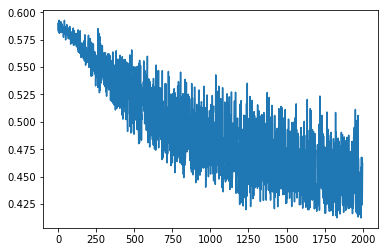

Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

 11%|█         | 2/19 [07:08<1:00:41, 214.23s/it]

Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/2

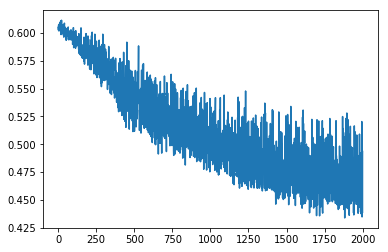

Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

 16%|█▌        | 3/19 [10:42<57:05, 214.12s/it]  

Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggf

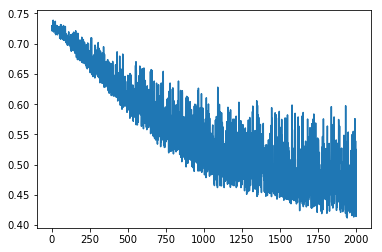

Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

 21%|██        | 4/19 [14:19<53:49, 215.28s/it]

Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/2

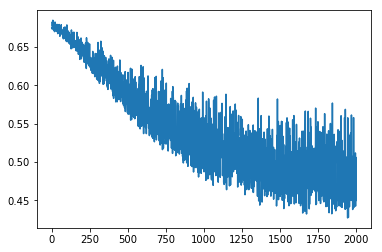

Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n008613/epsilon_0.1/png
Saving to /data/vggf

 26%|██▋       | 5/19 [17:58<50:29, 216.39s/it]

Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/2

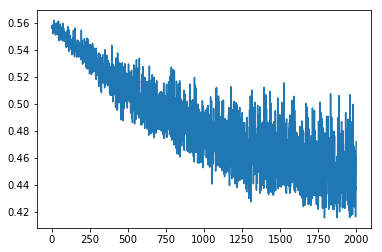

Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 32%|███▏      | 6/19 [21:33<46:45, 215.77s/it]

Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggf

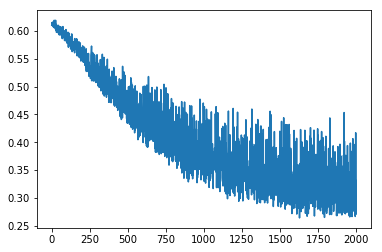

Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 37%|███▋      | 7/19 [25:06<43:01, 215.09s/it]

Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggf

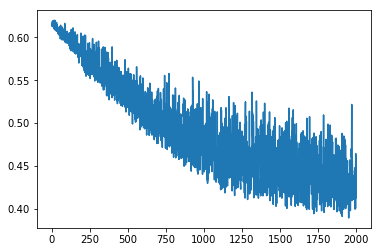

Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 42%|████▏     | 8/19 [28:38<39:13, 213.92s/it]

Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggf

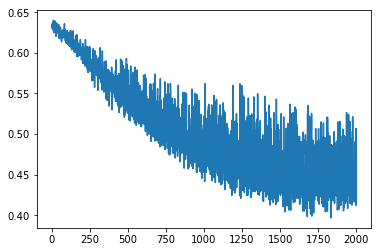

Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 47%|████▋     | 9/19 [32:13<35:43, 214.37s/it]

Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


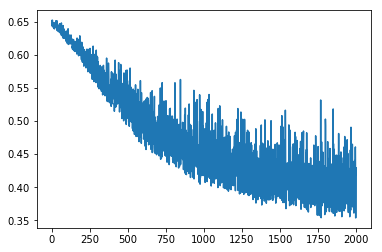

Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 53%|█████▎    | 10/19 [35:48<32:11, 214.62s/it]

Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scal

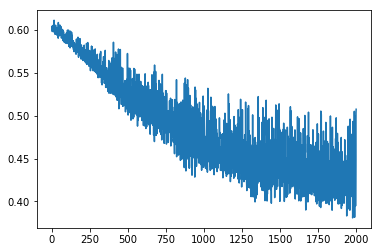

Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 58%|█████▊    | 11/19 [39:26<28:44, 215.56s/it]

Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


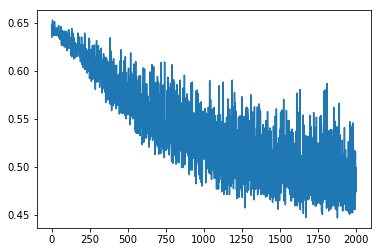

Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 63%|██████▎   | 12/19 [43:02<25:09, 215.70s/it]

Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


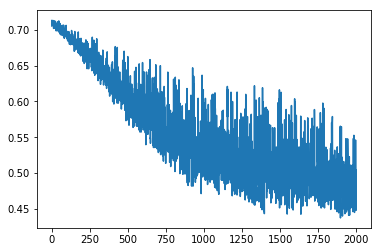

Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 68%|██████▊   | 13/19 [46:38<21:34, 215.72s/it]

Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/2

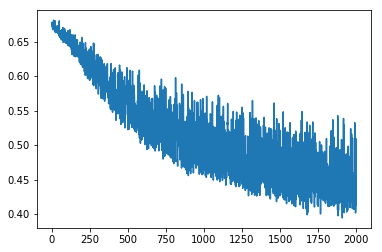

Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 74%|███████▎  | 14/19 [50:17<18:03, 216.77s/it]

Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


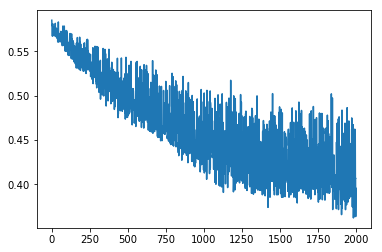

Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n008655/epsilon_0.1/png
Saving to /data/vggf

 79%|███████▉  | 15/19 [53:52<14:25, 216.38s/it]

Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_casia-webface/n009114/epsilon_0.1/png
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90


In [ ]:
for epsilon in [0.1, 0.25, 0,5]:
    generate_decoys_bigger_batches(
        "mean",
        "casia-webface",
        0.01,
        0.1,
        2000
    )